In [1]:
from pyspark.context import SparkContext

sc = SparkContext('local', 'test')

In [2]:
from pyspark.sql import SQLContext

spark = SQLContext(sc)

In [3]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://artifactory.dataxu.net/artifactory/api/pypi/pypi-virtual/simple/
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [7]:
import numpy as np
import pandas as pd
import re
import warnings

import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from adjustText import adjust_text
from textwrap import wrap

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.metrics import  classification_report, log_loss, roc_auc_score
import shap  

In [8]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 50

## IMPORT DATA

In [10]:
games = pd.read_csv('kaggle/input/nba-games/games.csv')
details = pd.read_csv('kaggle/input/nba-games/games_details.csv')
teams = pd.read_csv('kaggle/input/nba-games/teams.csv')
players = pd.read_csv('kaggle/input/nba-games/players.csv')
ranking = pd.read_csv('kaggle/input/nba-games/ranking.csv')

details['PLAYER_NAME_SHORT'] = details['PLAYER_NAME'].str.replace('^(.).*\s(.*)', '\\1.\\2')
details[["MINS", "SECS"]] = details.MIN.str.extract(r"([^:]+):(.*)")
details.loc[(~details.MIN.str.contains(':', na = True)), 'SECS'] = details.MIN
details.MINS = pd.to_numeric(details.MINS)
details.SECS = pd.to_numeric(details.SECS)
details['PLAY_TIME'] = np.round(details.MINS.fillna(0) + details.SECS/60)

games = games.loc[~games[['GAME_ID', 'GAME_DATE_EST']].duplicated()] #Leaving one entry per game
games['GAME_DATE_EST'] = pd.to_datetime(games.GAME_DATE_EST)

The default value of regex will change from True to False in a future version.


## FEATURE SELECTION

#### Preparing the predictive modelling dataset

As always, the crucial task when given NBA stats is to manage to predict the outcome of future games based on the already available stats. But while we could use the datasets as they are, it is much better to try to create new meaningful features to help with prediction accuracy.

The modelling dataset consists of the following components:

- Team ELO rating
- Team wins
- Team loses
- Missing players
- Team player efficiency

## ELO

Calculating ELO for each team

The main points of the calculation:

- Winning a game increases the ELO of the team and losing a game decreases it
- The amount of increase/decrease depends on
    a) the margin of victory 
    b) the pre-game expectations for the outcome of the game (which are based on the ELO rating of the two teams)
- Ratings are adjusted after each game
- One of the easiest way to assess the ELO figures is to have a look at the end-season results and see which teams finished at the top.

In [11]:
def mov_mult(mov, elo_diff):
    return (mov + 3)**0.8/(7.5 + 0.006*(elo_diff))

def win_prob(elo_diff):
    return 1/(10**(-elo_diff/400) + 1)

def update_elo(team_elo, game_data, k=20):
    if game_data.MOV < 0:        
        mult = mov_mult(-game_data.MOV, -game_data.ELO_DIFF)
        elo_change =  k*(game_data.HOME_WIN_PR)*mult
        team_elo.loc[team_elo.TEAM == game_data.HOME_TEAM_ID, 'ELO'] -= elo_change
        team_elo.loc[team_elo.TEAM == game_data.VISITOR_TEAM_ID, 'ELO'] += elo_change
    else:
        mult = mov_mult(game_data.MOV, game_data.ELO_DIFF)
        elo_change =  k*(1-game_data.HOME_WIN_PR)*mult
        team_elo.loc[team_elo.TEAM == game_data.HOME_TEAM_ID, 'ELO'] += elo_change
        team_elo.loc[team_elo.TEAM == game_data.VISITOR_TEAM_ID, 'ELO'] -= elo_change
        
elo_data = games[['GAME_DATE_EST', 'GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'PTS_home', 'PTS_away']].copy()
elo_data['MOV'] = elo_data['PTS_home'] - elo_data['PTS_away']
elo_data.sort_values('GAME_DATE_EST', inplace=True)
elo_data = elo_data.dropna()
elo_data[['HOME_ELO', 'VISITOR_ELO', 'ELO_DIFF', 'HOME_WIN_PR', 'VISITOR_WIN_PR']] = 0
elo_data.reset_index(inplace=True, drop=True)


teams_dict = dict(zip(teams.TEAM_ID, teams.ABBREVIATION))
team_elo = pd.DataFrame({'TEAM':pd.unique(elo_data[['HOME_TEAM_ID', 'VISITOR_TEAM_ID']].values.ravel('K')), 
                         'ELO':1500})
team_elo['NAME'] = team_elo.TEAM.map(teams_dict)
team_elo_l = []

current_season = 2003
home_elo_col = elo_data.columns.get_loc("HOME_ELO")
visitor_elo_col = elo_data.columns.get_loc("VISITOR_ELO")
home_team_col = elo_data.columns.get_loc('HOME_TEAM_ID')
visitor_team_col = elo_data.columns.get_loc('VISITOR_TEAM_ID')
elo_diff_col = elo_data.columns.get_loc('ELO_DIFF')
home_win_col = elo_data.columns.get_loc('HOME_WIN_PR')
visitor_win_col = elo_data.columns.get_loc('VISITOR_WIN_PR')

for i in range(len(elo_data)):
    if elo_data.iloc[i, elo_data.columns.get_loc('SEASON')] != current_season:
        team_elo_l.append(team_elo.sort_values(by = 'ELO', ascending = False).head(5).assign(SEASON = current_season))
        team_elo['ELO'] = 0.75*team_elo.ELO + 0.25*1500 # Reverting back to the mean for the start of each season
        current_season = elo_data.iloc[i, elo_data.columns.get_loc('SEASON')]
        
    elo_data.iloc[i, home_elo_col] = team_elo.loc[team_elo.TEAM == elo_data.iloc[i, home_team_col], 'ELO'].values + 100
    elo_data.iloc[i, visitor_elo_col] = team_elo.loc[team_elo.TEAM == elo_data.iloc[i, visitor_team_col], 'ELO'].values
    elo_data.iloc[i, elo_diff_col] = elo_data.iloc[i, home_elo_col] - elo_data.iloc[i, visitor_elo_col]
    elo_data.iloc[i, home_win_col] = win_prob(elo_data.iloc[i, elo_diff_col])
    elo_data.iloc[i, visitor_win_col] = 1-elo_data.iloc[i, home_win_col]
    update_elo(team_elo, elo_data.iloc[i])
team_elo_l.append(team_elo.sort_values(by = 'ELO', ascending = False).head(5).assign(SEASON = current_season))

### ELO Prediction

In [12]:
ranking['STANDINGSDATE'] = pd.to_datetime(ranking['STANDINGSDATE'])
ranking.sort_values('STANDINGSDATE', inplace = True)
ranking = ranking.loc[ranking.SEASON_ID // 10000 == 2]
ranking['SEASON_ID'] = ranking['SEASON_ID'] % 10000
ranking['MAX_S_GAMES'] = ranking.groupby('SEASON_ID').G.transform(max)

# Creating a df with season start and end for excluding preseason and playoff games
start_dates = ranking.loc[ranking.SEASON_ID > 2002].groupby('SEASON_ID')['STANDINGSDATE'].min().to_frame('FIRST_GAME').reset_index()
t = ranking.loc[(ranking.G == ranking.MAX_S_GAMES)].groupby(['SEASON_ID', 'STANDINGSDATE'])['TEAM_ID'].nunique().to_frame('TEAMS').reset_index()
playoff_dates = t.loc[(t.TEAMS == 30) | 
                      ((t.TEAMS == 28) & (t.SEASON_ID == 2012)) | 
                      ((t.TEAMS == 29) & (t.SEASON_ID == 2003))].groupby('SEASON_ID')['STANDINGSDATE'].min().to_frame('LAST_GAME').reset_index()
dates = start_dates.merge(playoff_dates, how = 'left')
dates.loc[dates.SEASON_ID == 2019, 'LAST_GAME'] = pd.to_datetime('2020-03-12') #Manually adding the end of regular season

# Filtering out details for non-regular season games
details = details.merge(games[['GAME_ID', 'GAME_DATE_EST', 'SEASON']], how = 'left')
details = details.merge(dates, left_on = 'SEASON', right_on = 'SEASON_ID', how = 'left')
details = details.loc[(details.LAST_GAME.isnull()) | ((details.GAME_DATE_EST <= details.LAST_GAME) & (details.GAME_DATE_EST > details.FIRST_GAME))]

# Filtering out games for non-regular season games
games = games.merge(dates, left_on = 'SEASON', right_on = 'SEASON_ID', how = 'inner')
games = games.loc[games.LAST_GAME.isnull() | ((games.GAME_DATE_EST <= games.LAST_GAME) & (games.GAME_DATE_EST > games.FIRST_GAME))]
games.drop(columns = ['SEASON_ID', 'FIRST_GAME', 'LAST_GAME'], inplace=True)

# Creating a new ranking df with regular season only and values that can be used for modeling 
ranking_short = ranking[['TEAM_ID', 'SEASON_ID', 'STANDINGSDATE', 'CONFERENCE', 'TEAM', 'G', 'W', 'L', 'HOME_RECORD', 'ROAD_RECORD']].merge(dates)
ranking_short = ranking_short.loc[(ranking_short.STANDINGSDATE >= ranking_short.FIRST_GAME) & (ranking_short.STANDINGSDATE <= ranking_short.LAST_GAME)]
ranking_short = ranking_short.loc[ranking_short.G > 0]
ranking_short[['HOME_W', 'HOME_L']] = ranking_short.HOME_RECORD.str.split('-', expand = True)
ranking_short[['AWAY_W', 'AWAY_L']] = ranking_short.ROAD_RECORD.str.split('-', expand = True)
ranking_short[['HOME_W', 'HOME_L', 'AWAY_W', 'AWAY_L']] = ranking_short[['HOME_W', 'HOME_L', 'AWAY_W', 'AWAY_L']].apply(pd.to_numeric)
ranking_short.drop(columns = ['SEASON_ID', 'FIRST_GAME', 'LAST_GAME', 'HOME_RECORD', 'ROAD_RECORD'], inplace = True)
ranking_short.sort_values('STANDINGSDATE', inplace = True)

# Creating a new games df with regular season only
games_short = pd.merge(games[['GAME_ID', 'GAME_DATE_EST', 'SEASON', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'HOME_TEAM_WINS']], dates, left_on = 'SEASON', right_on = 'SEASON_ID')
games_short = games_short.loc[(games_short.GAME_DATE_EST > games_short.FIRST_GAME) & (games_short.GAME_DATE_EST <= games_short.LAST_GAME)]
games_short.drop(columns = ['SEASON_ID', 'FIRST_GAME', 'LAST_GAME'], inplace = True)
games_short.sort_values('GAME_DATE_EST', inplace = True)

## MISSING PLAYERS

In [13]:
missing_players = details.groupby(['GAME_ID', 'TEAM_ID'], as_index=False)['COMMENT'].agg(lambda x: ((x.notnull()) & (~x.str.contains('coach', case=False, na=False))).sum())
missing_players.rename(columns = {'COMMENT':'MISSING_PLAYERS'}, inplace = True)

## EFFICENCY

In [14]:
details['FGMISSES'] = details.FGA - details.FGM
details['FTMISSES'] = details.FTA - details.FTM
details['EFF'] = details.PTS + details.REB + details.AST + details.STL + details.BLK - (details.TO + details.FGMISSES + details.FTMISSES)

# Creating the efficiency dataset
eff = details[['PLAYER_NAME', 'PLAYER_ID', 'SEASON', 'EFF']].copy()
eff.dropna(inplace=True)
eff = eff.groupby(['PLAYER_NAME', 'PLAYER_ID', 'SEASON'], as_index=False).sum()
eff.sort_values('EFF', ascending=False, inplace=True)
top_players = eff.groupby('SEASON', as_index=False).head(30).copy()
top_players['NEXT_SEASON'] = top_players.SEASON + 1
eff['NEXT_SEASON'] = eff.SEASON + 1

# Efficiency per game per team
per_game_eff = details.loc[details.COMMENT.isnull()][['GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'SEASON']].merge(eff, left_on=['PLAYER_ID', 'SEASON'], right_on=['PLAYER_ID', 'NEXT_SEASON'], how='left')
pge = per_game_eff.groupby(['GAME_ID', 'TEAM_ID'], as_index=False).EFF.mean()
pge.dropna(inplace= True)

## COMBINE DATA

In [15]:
# Combining all the data to create the full dataset
input_data = pd.merge_asof(games_short, ranking_short, left_on = 'GAME_DATE_EST', right_on = 'STANDINGSDATE', 
                     left_by = 'HOME_TEAM_ID', right_by = 'TEAM_ID', allow_exact_matches = False)
input_data = input_data.loc[~input_data.TEAM_ID.isnull()]
input_data = pd.merge_asof(input_data, ranking_short.add_suffix("_VISITOR"), left_on = 'GAME_DATE_EST', right_on = 'STANDINGSDATE_VISITOR', 
                     left_by = 'VISITOR_TEAM_ID', right_by = 'TEAM_ID_VISITOR', allow_exact_matches = False)

input_data.loc[(input_data.GAME_DATE_EST.dt.month <= 12) & (input_data.GAME_DATE_EST.dt.month > 9) & (input_data.G > 50), ['G', 'W', 'L', 'HOME_W', 'HOME_L', 'AWAY_W', 'AWAY_L']] = 0
input_data.loc[(input_data.GAME_DATE_EST.dt.month <= 12) & (input_data.GAME_DATE_EST.dt.month > 9) & (input_data.G_VISITOR > 50), ['G_VISITOR', 'W_VISITOR', 'L_VISITOR', 'HOME_W_VISITOR', 'HOME_L_VISITOR', 'AWAY_W_VISITOR', 'AWAY_L_VISITOR']] = 0

#Adding player efficiency
input_data = input_data.merge(pge, left_on=['HOME_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_something'))
input_data = input_data.merge(pge, left_on=['VISITOR_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_VISITOR'))
input_data.drop(columns=['TEAM_ID_something', 'TEAM_ID_VISITOR'], inplace=True)

#Adding missing players
input_data = input_data.merge(missing_players, left_on=['GAME_ID', 'HOME_TEAM_ID'], right_on=['GAME_ID', 'TEAM_ID'])
input_data = input_data.merge(missing_players, left_on=['GAME_ID', 'VISITOR_TEAM_ID'], right_on=['GAME_ID', 'TEAM_ID'], suffixes=(None, '_VISITOR'))

# Adding ELO
input_data = input_data.merge(elo_data[['GAME_ID', 'HOME_ELO', 'VISITOR_ELO']])

input_data['HOME_TEAM'] = input_data['HOME_TEAM_ID'].map(teams_dict)
input_data['VISITOR_TEAM'] = input_data['VISITOR_TEAM_ID'].map(teams_dict)

input_data = input_data.drop(columns = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'TEAM_ID', 'TEAM', 'TEAM_ID_x', 'TEAM_ID_y', 'STANDINGSDATE', 'TEAM_VISITOR', 'STANDINGSDATE_VISITOR'])
input_data['ELO_DIFF'] = input_data.HOME_ELO - input_data.VISITOR_ELO
input_data['MISSING_PLAYER_DIFF'] = input_data.MISSING_PLAYERS - input_data.MISSING_PLAYERS_VISITOR
input_data['EFF_DIFF'] = input_data.EFF - input_data.EFF_VISITOR
input_data['MONTH'] = input_data.GAME_DATE_EST.dt.month

input_data.drop(columns = ['HOME_TEAM', 'VISITOR_TEAM', 'CONFERENCE', 'CONFERENCE_VISITOR', 'GAME_DATE_EST'], inplace=True)

In [16]:
train_data = input_data.loc[(input_data.SEASON < 2018) & (input_data.SEASON > 2005)]
valid_data = input_data.loc[input_data.SEASON == 2018]
test_data = input_data.loc[input_data.SEASON == 2019]
full_train_data = pd.concat([train_data, valid_data], axis = 0)

X, y = train_data.drop(columns = ['HOME_TEAM_WINS']), train_data.HOME_TEAM_WINS
valid_X, valid_y = valid_data.drop(columns = ['HOME_TEAM_WINS']), valid_data.HOME_TEAM_WINS
test_X, test_y = test_data.drop(columns = ['HOME_TEAM_WINS']), test_data.HOME_TEAM_WINS
full_train_X, full_train_y = full_train_data.drop(columns = ['HOME_TEAM_WINS', 'SEASON', 'GAME_ID']), full_train_data.HOME_TEAM_WINS

train_games = X[['SEASON', 'GAME_ID']]
valid_games = valid_X[['SEASON', 'GAME_ID']]
test_games = test_X[['SEASON', 'GAME_ID']]

X.drop(columns = ['SEASON', 'GAME_ID'], inplace=True)
valid_X.drop(columns = ['SEASON', 'GAME_ID'], inplace = True)
test_X.drop(columns = ['SEASON', 'GAME_ID'], inplace = True)

## BASELINE

In [17]:
from sklearn.metrics import accuracy_score

print('ELO accuracy: ' + str(np.round(accuracy_score(test_X.ELO_DIFF >= 0, test_y)*100,2)) + ' %')
results_l = full_train_data
results_l = results_l.append(['ELO', accuracy_score(test_X.ELO_DIFF >= 0, test_y)*100, 1])

ELO accuracy: 65.53 %


In [18]:
train_data.columns

Index(['GAME_ID', 'SEASON', 'HOME_TEAM_WINS', 'G', 'W', 'L', 'HOME_W',
       'HOME_L', 'AWAY_W', 'AWAY_L', 'G_VISITOR', 'W_VISITOR', 'L_VISITOR',
       'HOME_W_VISITOR', 'HOME_L_VISITOR', 'AWAY_W_VISITOR', 'AWAY_L_VISITOR',
       'EFF', 'EFF_VISITOR', 'MISSING_PLAYERS', 'MISSING_PLAYERS_VISITOR',
       'HOME_ELO', 'VISITOR_ELO', 'ELO_DIFF', 'MISSING_PLAYER_DIFF',
       'EFF_DIFF', 'MONTH'],
      dtype='object')

## FINAL DATAFRAME

Features:
- GAME_ID
- SEASON
- HOME_TEAM_WINS: label
- G: Games played 
- W: Wins
- L: Losses
- HOME_W: Home wins
- HOME_L: Home losses
- AWAY_W: Away wins
- AWAY_L: Away losses
- G_VISITOR: Visitor games playes
- W_VISITOR: Visitor wins
- L_VISITOR: Visitor losses
- HOME_W_VISITOR: Visitor home wins
- HOME_L_VISITOR: Visitor home losses
- AWAY_W_VISITOR: Visitor away wins
- AWAY_L_VISITOR: Visitor away losses
- EFF: Mean of Player Efficiency (Player Efficiency = Pts + Rebs + Ast + Stl + Blk – (TO + FG Misses + FT Misses))
- EFF_VISITOR: Visitor team efficency
- MISSING_PLAYERS: missing players
- MISSING_PLAYERS_VISITOR: Visitor team missing players
- HOME_ELO: ELO ranking for home team
- VISITOR_ELO: ELO ranking for visitor team
- ELO_DIFF: ELO difference
- MISSING_PLAYER_DIFF: missing player difference
- EFF_DIFF: Efficency difference
- MONTH

In [19]:
train_data.describe()

,GAME_ID,SEASON,HOME_TEAM_WINS,G,W,L,HOME_W,HOME_L,AWAY_W,AWAY_L,G_VISITOR,W_VISITOR,L_VISITOR,HOME_W_VISITOR,HOME_L_VISITOR,AWAY_W_VISITOR,AWAY_L_VISITOR,EFF,EFF_VISITOR,MISSING_PLAYERS,MISSING_PLAYERS_VISITOR,HOME_ELO,VISITOR_ELO,ELO_DIFF,MISSING_PLAYER_DIFF,EFF_DIFF,MONTH
count,1.448200e+04,14482.000000,14482.000000,14482.000000,14482.000000,14482.000000,14482.000000,14482.000000,14482.000000,14482.000000,14482.000000,14482.000000,14482.000000,14482.000000,14482.000000,14482.000000,14482.000000,14482.000000,14482.000000,14482.000000,14482.000000,14482.000000,14482.000000,14482.000000,14482.000000,14482.000000,14482.000000
mean,2.115146e+07,2011.508493,0.591838,40.043778,19.973346,20.070432,11.663582,8.112692,8.309764,11.957741,40.063803,20.082516,19.981287,11.963265,8.324265,8.119251,11.657023,761.778039,757.976993,0.394628,0.405124,1600.321175,1499.586778,100.734397,-0.010496,3.801046,5.654744
std,3.480834e+05,3.480821,0.491510,23.432331,13.876446,13.876118,8.053448,6.279443,6.263798,8.068830,23.392433,13.862073,13.846505,8.155651,6.384787,6.146391,7.933714,154.838963,158.592932,0.744276,0.756809,109.089346,109.271538,156.277761,1.037732,202.200862,4.474094
min,2.060000e+07,2006.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,115.400000,209.750000,0.000000,0.000000,1250.932274,1151.834719,-443.958226,-5.000000,-771.666667,1.000000
25%,2.080117e+07,2008.000000,0.000000,20.000000,9.000000,9.000000,5.000000,3.000000,3.000000,5.000000,20.000000,9.000000,9.000000,5.000000,3.000000,3.000000,5.000000,657.931818,650.832386,0.000000,0.000000,1523.996478,1422.817112,-5.248020,0.000000,-128.827778,2.000000
50%,2.120012e+07,2012.000000,1.000000,40.000000,18.000000,18.000000,11.000000,7.000000,7.000000,11.000000,40.000000,18.000000,18.000000,11.000000,7.000000,7.000000,11.000000,765.500000,762.348485,0.000000,0.000000,1601.709946,1500.288457,100.334665,0.000000,4.886111,3.000000
75%,2.150006e+07,2015.000000,1.000000,60.000000,29.000000,29.000000,17.000000,12.000000,12.000000,18.000000,60.000000,29.000000,29.000000,18.000000,12.000000,12.000000,17.000000,868.694805,865.666667,1.000000,1.000000,1679.179847,1577.893258,206.829221,0.000000,133.852679,11.000000
max,2.170123e+07,2017.000000,1.000000,81.000000,72.000000,69.000000,39.000000,33.000000,34.000000,37.000000,81.000000,71.000000,71.000000,40.000000,34.000000,33.000000,37.000000,1445.571429,1360.285714,5.000000,5.000000,1906.757662,1809.794890,675.885059,5.000000,857.250000,12.000000


## PREDICTION

In [24]:
from pyspark.sql.types import *
from pyspark.sql.functions import regexp_replace, col, when, udf
from pyspark.ml.feature import Bucketizer
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import RandomForestClassifier

assembler = VectorAssembler(
    inputCols=['GAME_ID', 'SEASON', 'G', 'W', 'L', 
       'EFF', 'EFF_VISITOR',
       'HOME_ELO', 'VISITOR_ELO', 'ELO_DIFF',
       'EFF_DIFF', 'MONTH'],
    outputCol="features",
    handleInvalid='keep')

rf = RandomForestClassifier(labelCol="HOME_TEAM_WINS", featuresCol="features", numTrees=10)

pipeline = Pipeline(stages = [assembler, rf])

In [25]:
training_df = spark.createDataFrame(train_data)
test_df = spark.createDataFrame(test_data)

In [26]:
model = pipeline.fit(training_df)

In [27]:
df_predictions = model.transform(test_df)
df_pandas = df_predictions.toPandas()

In [28]:
df_pandas[["HOME_TEAM_WINS", "prediction", "probability"]]

,HOME_TEAM_WINS,prediction,probability
0,0,0.0,"[0.6238957899364606, 0.3761042100635394]"
1,1,0.0,"[0.6053008541830809, 0.39469914581691923]"
2,1,1.0,"[0.3653286678819158, 0.6346713321180842]"
3,1,1.0,"[0.23015504160262262, 0.7698449583973774]"
4,1,1.0,"[0.27815173889305994, 0.7218482611069401]"
...,...,...,...
964,0,1.0,"[0.20166274802290696, 0.7983372519770932]"
965,1,1.0,"[0.17283405700003618, 0.8271659429999639]"
966,0,1.0,"[0.17283405700003618, 0.8271659429999639]"
967,1,1.0,"[0.46042088840206485, 0.539579111597935]"


In [29]:
df_predictions.createOrReplaceTempView('predictions_dataset')
porcentaje_de_aciertos = spark.sql("select (1 - mean(abs(HOME_TEAM_WINS - prediction))) as Porcentaje_de_Aciertos from predictions_dataset")
porcentaje_de_aciertos.show()

+----------------------+
|Porcentaje_de_Aciertos|
+----------------------+
|    0.6615067079463364|
+----------------------+



In [30]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="HOME_TEAM_WINS", rawPredictionCol="prediction", metricName='areaUnderROC')
auc = evaluator.evaluate(df_predictions)
auc

0.6478540200010328

## SIMULATE PLAYOFFS

In [31]:
used_features_df = test_df['GAME_ID', 'SEASON', 'G', 'W', 'L', 'G_VISITOR', 'W_VISITOR', 'L_VISITOR',
       'EFF', 'EFF_VISITOR', 'MISSING_PLAYERS', 'MISSING_PLAYERS_VISITOR',
       'HOME_ELO', 'VISITOR_ELO', 'ELO_DIFF', 'MISSING_PLAYER_DIFF',
       'EFF_DIFF', 'MONTH', 'HOME_L', 'AWAY_W', 'HOME_W', 'AWAY_L', 'HOME_L_VISITOR', 'AWAY_W_VISITOR', 'AWAY_L_VISITOR', 'HOME_W_VISITOR']
used_features_df.toPandas()

,GAME_ID,SEASON,G,W,L,G_VISITOR,W_VISITOR,L_VISITOR,EFF,EFF_VISITOR,MISSING_PLAYERS,MISSING_PLAYERS_VISITOR,HOME_ELO,VISITOR_ELO,ELO_DIFF,MISSING_PLAYER_DIFF,EFF_DIFF,MONTH,HOME_L,AWAY_W,HOME_W,AWAY_L,HOME_L_VISITOR,AWAY_W_VISITOR,AWAY_L_VISITOR,HOME_W_VISITOR
0,21900013,2019,0.0,0.0,0.0,0,0,0,780.800000,1064.400000,0,0,1655.731365,1621.699898,34.031467,0,-283.600000,10,0.0,0.0,0.0,0.0,0,0,0,0
1,21900012,2019,0.0,0.0,0.0,0,0,0,793.166667,944.666667,0,0,1465.416193,1476.816736,-11.400543,0,-151.500000,10,0.0,0.0,0.0,0.0,0,0,0,0
2,21900011,2019,0.0,0.0,0.0,0,0,0,1133.000000,895.888889,0,0,1638.623913,1513.302133,125.321780,0,237.111111,10,0.0,0.0,0.0,0.0,0,0,0,0
3,21900010,2019,0.0,0.0,0.0,0,0,0,1063.000000,790.100000,0,0,1619.562937,1302.885599,316.677338,0,272.900000,10,0.0,0.0,0.0,0.0,0,0,0,0
4,21900009,2019,0.0,0.0,0.0,0,0,0,750.666667,594.125000,0,1,1586.787392,1462.458666,124.328726,-1,156.541667,10,0.0,0.0,0.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964,21900968,2019,62.0,49.0,13.0,63,29,34,990.600000,761.000000,0,0,1788.962368,1461.615887,327.346481,0,229.600000,3,7.0,26.0,23.0,6.0,14,11,20,18
965,21900971,2019,64.0,38.0,26.0,65,20,45,826.700000,275.000000,0,1,1659.553588,1338.215509,321.338079,-1,551.700000,3,2.0,10.0,28.0,24.0,22,9,23,11
966,21900970,2019,64.0,41.0,23.0,64,22,42,648.000000,443.600000,0,0,1677.972007,1364.393094,313.578913,0,204.400000,3,4.0,14.0,27.0,19.0,21,12,21,10
967,21900973,2019,66.0,39.0,27.0,64,43,21,805.333333,1090.888889,0,0,1671.779620,1590.171263,81.608357,0,-285.555556,3,15.0,21.0,18.0,12.0,8,18,13,25


In [32]:
season_2019_df = used_features_df[used_features_df['SEASON'] == 2019]
season_2019_df.toPandas()
joined_df = season_2019_df.toPandas().join(games.set_index('GAME_ID'), on='GAME_ID', how='left', lsuffix='_left', rsuffix='_right')
joined_df

,GAME_ID,SEASON_left,G,W,L,G_VISITOR,W_VISITOR,L_VISITOR,EFF,EFF_VISITOR,MISSING_PLAYERS,MISSING_PLAYERS_VISITOR,HOME_ELO,VISITOR_ELO,ELO_DIFF,MISSING_PLAYER_DIFF,EFF_DIFF,MONTH,HOME_L,AWAY_W,HOME_W,AWAY_L,HOME_L_VISITOR,AWAY_W_VISITOR,AWAY_L_VISITOR,HOME_W_VISITOR,GAME_DATE_EST,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON_right,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,21900013,2019,0.0,0.0,0.0,0,0,0,780.800000,1064.400000,0,0,1655.731365,1621.699898,34.031467,0,-283.600000,10,0.0,0.0,0.0,0.0,0,0,0,0,2019-10-23,Final,1610612757,1610612743,2019,1610612757,100.0,0.414,0.913,0.250,13.0,48.0,1610612743,108.0,0.420,0.815,0.563,24.0,45.0,0
1,21900012,2019,0.0,0.0,0.0,0,0,0,793.166667,944.666667,0,0,1465.416193,1476.816736,-11.400543,0,-151.500000,10,0.0,0.0,0.0,0.0,0,0,0,0,2019-10-23,Final,1610612756,1610612758,2019,1610612756,124.0,0.500,0.833,0.333,31.0,44.0,1610612758,95.0,0.391,0.654,0.345,17.0,47.0,1
2,21900011,2019,0.0,0.0,0.0,0,0,0,1133.000000,895.888889,0,0,1638.623913,1513.302133,125.321780,0,237.111111,10,0.0,0.0,0.0,0.0,0,0,0,0,2019-10-23,Final,1610612762,1610612760,2019,1610612762,100.0,0.444,0.700,0.250,15.0,49.0,1610612760,95.0,0.386,0.677,0.370,15.0,48.0,1
3,21900010,2019,0.0,0.0,0.0,0,0,0,1063.000000,790.100000,0,0,1619.562937,1302.885599,316.677338,0,272.900000,10,0.0,0.0,0.0,0.0,0,0,0,0,2019-10-23,Final,1610612759,1610612752,2019,1610612759,120.0,0.506,0.806,0.333,22.0,51.0,1610612752,111.0,0.468,0.722,0.333,24.0,39.0,1
4,21900009,2019,0.0,0.0,0.0,0,0,0,750.666667,594.125000,0,1,1586.787392,1462.458666,124.328726,-1,156.541667,10,0.0,0.0,0.0,0.0,0,0,0,0,2019-10-23,Final,1610612742,1610612764,2019,1610612742,108.0,0.461,0.818,0.306,17.0,46.0,1610612764,100.0,0.398,0.833,0.268,26.0,47.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964,21900968,2019,62.0,49.0,13.0,63,29,34,990.600000,761.000000,0,0,1788.962368,1461.615887,327.346481,0,229.600000,3,7.0,26.0,23.0,6.0,14,11,20,18,2020-03-10,Final,1610612747,1610612751,2019,1610612747,102.0,0.460,0.583,0.375,24.0,46.0,1610612751,104.0,0.411,0.739,0.325,24.0,47.0,0
965,21900971,2019,64.0,38.0,26.0,65,20,45,826.700000,275.000000,0,1,1659.553588,1338.215509,321.338079,-1,551.700000,3,2.0,10.0,28.0,24.0,22,9,23,11,2020-03-11,Final,1610612755,1610612765,2019,1610612755,124.0,0.506,0.813,0.424,28.0,50.0,1610612765,106.0,0.464,0.680,0.314,25.0,32.0,1
966,21900970,2019,64.0,41.0,23.0,64,22,42,648.000000,443.600000,0,0,1677.972007,1364.393094,313.578913,0,204.400000,3,4.0,14.0,27.0,19.0,21,12,21,10,2020-03-11,Final,1610612748,1610612766,2019,1610612748,98.0,0.464,0.833,0.341,32.0,36.0,1610612766,109.0,0.451,0.818,0.500,20.0,50.0,0
967,21900973,2019,66.0,39.0,27.0,64,43,21,805.333333,1090.888889,0,0,1671.779620,1590.171263,81.608357,0,-285.555556,3,15.0,21.0,18.0,12.0,8,18,13,25,2020-03-11,Final,1610612742,1610612743,2019,1610612742,113.0,0.457,0.739,0.343,23.0,52.0,1610612743,97.0,0.470,0.625,0.359,23.0,40.0,1


In [33]:
homes = joined_df[['HOME_TEAM_ID', 'HOME_ELO', 'EFF', 'MISSING_PLAYERS', 'G', 'W', 'L']]
visitors = joined_df[['VISITOR_TEAM_ID', 'VISITOR_ELO', 'EFF_VISITOR', 'MISSING_PLAYERS_VISITOR', 'G_VISITOR', 'W_VISITOR', 'L_VISITOR']]
homes = homes.rename(columns={'HOME_TEAM_ID': 'TEAM_ID', 'HOME_ELO': 'ELO' })
visitors = visitors.rename(columns={'VISITOR_TEAM_ID': 'TEAM_ID', 'VISITOR_ELO': 'ELO', 'EFF_VISITOR': 'EFF',
                                    'MISSING_PLAYERS_VISITOR': 'MISSING_PLAYERS', 'G_VISITOR': 'G', 'W_VISITOR': 'W', 'L_VISITOR': 'L'})
concat = pd.concat([visitors, homes])
team_data_df = concat.groupby('TEAM_ID').max('G')

teams_small = teams[['ABBREVIATION', 'NICKNAME','TEAM_ID']]

In [34]:
homes = joined_df[['HOME_TEAM_ID', 'HOME_ELO', 'EFF', 'MISSING_PLAYERS', 'G', 'W', 'L','HOME_W','HOME_L','AWAY_W','AWAY_L']]
visitors = joined_df[['VISITOR_TEAM_ID', 'VISITOR_ELO', 'EFF_VISITOR', 'MISSING_PLAYERS_VISITOR', 'G_VISITOR', 'W_VISITOR', 'L_VISITOR','HOME_W_VISITOR','HOME_L_VISITOR','AWAY_W_VISITOR','AWAY_L_VISITOR']]
homes = homes.rename(columns={'HOME_TEAM_ID': 'TEAM_ID', 'HOME_ELO': 'ELO' })
visitors = visitors.rename(columns={'VISITOR_TEAM_ID': 'TEAM_ID', 'VISITOR_ELO': 'ELO', 'EFF_VISITOR': 'EFF',
                                    'MISSING_PLAYERS_VISITOR': 'MISSING_PLAYERS', 'G_VISITOR': 'G', 'W_VISITOR': 'W', 'L_VISITOR': 'L','HOME_W_VISITOR':'HOME_W','HOME_L_VISITOR':'HOME_L','AWAY_W_VISITOR':'AWAY_W','AWAY_L_VISITOR':'AWAY_L'})
concat = pd.concat([visitors, homes])
team_data_df = concat.groupby('TEAM_ID').max('G')

teams_small = teams[['ABBREVIATION', 'NICKNAME','TEAM_ID']]

## TEAM DATA

In [35]:
team_data = team_data_df.join(teams_small.set_index('TEAM_ID'), on='TEAM_ID', how='left', lsuffix='_left', rsuffix='_right')
team_data

,ELO,EFF,MISSING_PLAYERS,G,W,L,HOME_W,HOME_L,AWAY_W,AWAY_L,ABBREVIATION,NICKNAME
TEAM_ID,,,,,,,,,,,,
1610612737,1507.793798,978.500000,2,66.0,20.0,46.0,14.0,19.0,6.0,27.0,ATL,Hawks
1610612738,1789.682073,995.625000,2,63.0,42.0,21.0,23.0,9.0,19.0,12.0,BOS,Celtics
1610612739,1466.823732,1010.500000,3,64.0,19.0,45.0,11.0,25.0,8.0,20.0,CLE,Cavaliers
1610612740,1655.247664,945.000000,4,63.0,27.0,36.0,13.0,19.0,14.0,17.0,NOP,Pelicans
1610612741,1512.049154,1001.166667,3,64.0,21.0,43.0,13.0,20.0,8.0,23.0,CHI,Bulls
1610612742,1719.369751,886.250000,1,66.0,39.0,27.0,18.0,15.0,21.0,12.0,DAL,Mavericks
1610612743,1759.700579,1154.625000,1,64.0,43.0,21.0,25.0,8.0,18.0,13.0,DEN,Nuggets
1610612744,1675.967024,906.625000,3,64.0,15.0,49.0,8.0,25.0,7.0,24.0,GSW,Warriors
1610612745,1757.760819,1153.857143,1,63.0,39.0,24.0,21.0,10.0,18.0,14.0,HOU,Rockets


# SIMULATE

Una vez terminados los partidos de temporada, se simularan los playoffs. El primer cruce esta dado por como terminaron los equipos en la etapa de temporada. 
En una primera instancia se determina el primer cruce (a mano). 

Nicknames:
- Hawks
- Celtics
- Cavaliers
- Pelicans
- Bulls
- Mavericks
- Nuggets
- Warriors
- Rockets
- Clippers
- Lakers
- Heat
- Bucks
- Timberwolves
- Nets
- Knicks
- Magic
- Pacers
- 76ers
- Suns
- Trail Blazers
- Kings
- Spurs
- Thunder
- Raptors
- Jazz
- Grizzlies
- Wizards
- Pistons
- Hornets

Primeros cruces conferencia este:
- Bucks - Pistons
- Raptos - Magic
- 76ers - Nets
- Celtics - Pacers

Primeros cruces conferencia oeste:
- Warriors - Clippers
- Nuggets - Spurs
- Trail Blazers - Thunder
- Rockets - Jazz

Estructura de playoff:
<br>
- Cruce 1: Equipo 1 vs Equipo 8
- Cruce 2: Equipo 2 vs Equipo 7
- Cruce 3: Equipo 3 vs Equipo 6
- Cruce 4: Equipo 4 vs Equipo 5
<br><br>
- Cruce 5: Gandor Cruce 1 vs ganador Cruce 4
- Cruce 6: Ganador Cruce 2 vs ganador Cruce 3
<br><br>
- Cruce 7: Ganador Cruce 5 vs ganador Cruce 6

In [36]:
import numpy as np
import pandas as pd

def rnd(home, home_elo, visit, visit_elo):
    if np.random.rand() < 0.5:
        home, visit = visit, home
        home_elo, visit_elo = visit_elo, home_elo
    thld = home_elo / (home_elo + visit_elo)    
    if np.random.rand() < thld:
        return home
    else:
        return visit
    
def simulate_series(home, visit):
    home_elo = team_data[team_data['NICKNAME'] == home]['ELO'].tolist()[0]
    visit_elo = team_data[team_data['NICKNAME'] == home]['ELO'].tolist()[0]
    serie = [rnd(home, home_elo, visit, visit_elo) for i in range(0,7)]
    if serie.count(home) >= 4:
        return home
    else: 
        return visit 
    
def simulate_conference(equipo_1, equipo_2, equipo_3, equipo_4, equipo_5, equipo_6, equipo_7, equipo_8):
    series_winner_1 = simulate_series(equipo_1, equipo_8)
    series_winner_2 = simulate_series(equipo_2, equipo_7)
    series_winner_3 = simulate_series(equipo_3, equipo_6)
    series_winner_4 = simulate_series(equipo_4, equipo_5)
    series_winner_5 = simulate_series(series_winner_1, series_winner_4)
    series_winner_6 = simulate_series(series_winner_2, series_winner_3)
    return simulate_series(series_winner_5, series_winner_6)

def simulate_final(east_conf_winner, west_conf_winner):
    return simulate_series(east_conf_winner, west_conf_winner)

def simulate_playoffs(equipo_1, equipo_2, equipo_3, equipo_4, equipo_5, equipo_6, equipo_7, equipo_8,equipo_9, equipo_10, equipo_11, equipo_12, equipo_13, equipo_14, equipo_15, equipo_16):
    east_conf_winner = simulate_conference(equipo_1, equipo_2, equipo_3, equipo_4, equipo_5, equipo_6, equipo_7, equipo_8)
    west_conf_winner = simulate_conference(equipo_9, equipo_10, equipo_11, equipo_12, equipo_13, equipo_14, equipo_15, equipo_16)
    return simulate_final(east_conf_winner, west_conf_winner)

#### Para simular Bucks - Pistons se debe determinar el threshold de la siguiente manera:

    THLD = ELO_Bucks / (ELO_Bucks + ELO_Pistons)
    
#### Luego, se simula la serie que consta de 7 partidos. El ganador de la serie pasa a la siguiente fase

In [37]:
home = "Bucks"
visit = "Pistons"
home_elo = 1866.567583
visit_elo = 1583.048396
series_winner = simulate_series(home, visit)
series_winner

'Bucks'

### Conferencia oeste

In [38]:
equipo_1 = 'Lakers'
equipo_2 = 'Clippers' 
equipo_3 = 'Nuggets'
equipo_4 = 'Rockets'
equipo_5 = 'Thunder'
equipo_6 = 'Jazz'
equipo_7 = 'Mavericks'
equipo_8 = 'Trail Blazers'


In [39]:
conf_teams = ['Warriors', 'Nuggets', 'Trail Blazers', 'Rockets', 'Jazz', 'Thunder', 'Spurs', 'Clippers']

team_data[team_data['NICKNAME'].isin(conf_teams)].sort_values('ELO').head(30)

,ELO,EFF,MISSING_PLAYERS,G,W,L,HOME_W,HOME_L,AWAY_W,AWAY_L,ABBREVIATION,NICKNAME
TEAM_ID,,,,,,,,,,,,
1610612759,1642.871493,1063.000000,1,62.0,26.0,36.0,15.0,14.0,11.0,22.0,SAS,Spurs
1610612757,1664.141638,844.000000,4,65.0,28.0,37.0,17.0,14.0,11.0,23.0,POR,Trail Blazers
1610612744,1675.967024,906.625000,3,64.0,15.0,49.0,8.0,25.0,7.0,24.0,GSW,Warriors
1610612760,1702.793823,1013.571429,2,63.0,39.0,24.0,20.0,13.0,19.0,11.0,OKC,Thunder
1610612746,1731.059965,1197.900000,2,63.0,43.0,20.0,25.0,7.0,18.0,13.0,LAC,Clippers
1610612762,1740.403296,1231.000000,1,63.0,41.0,22.0,21.0,9.0,20.0,13.0,UTA,Jazz
1610612745,1757.760819,1153.857143,1,63.0,39.0,24.0,21.0,10.0,18.0,14.0,HOU,Rockets
1610612743,1759.700579,1154.625000,1,64.0,43.0,21.0,25.0,8.0,18.0,13.0,DEN,Nuggets


### Conferencia este

In [40]:

equipo_9 = 'Bucks'
equipo_10 = 'Raptors'
equipo_11 = 'Celtics'
equipo_12 = 'Pacers'
equipo_13 = 'Heat'
equipo_14 = '76ers'
equipo_15 = 'Nets'
equipo_16 = 'Magic'

In [41]:
conf_teams = ['Bucks', 'Raptors', '76ers', 'Celtics', 'Pacers', 'Nets', 'Magic', 'Pistons']

team_data[team_data['NICKNAME'].isin(conf_teams)].sort_values('ELO').head(30)

,ELO,EFF,MISSING_PLAYERS,G,W,L,HOME_W,HOME_L,AWAY_W,AWAY_L,ABBREVIATION,NICKNAME
TEAM_ID,,,,,,,,,,,,
1610612765,1583.048396,770.900000,3,65.0,20.0,45.0,11.0,22.0,9.0,23.0,DET,Pistons
1610612751,1605.061521,1007.222222,1,63.0,29.0,34.0,18.0,14.0,11.0,20.0,BKN,Nets
1610612753,1626.374544,1064.000000,1,64.0,29.0,35.0,16.0,15.0,13.0,20.0,ORL,Magic
1610612754,1680.081185,962.000000,1,64.0,39.0,25.0,21.0,10.0,18.0,15.0,IND,Pacers
1610612755,1736.635902,1115.777778,1,64.0,38.0,26.0,28.0,2.0,10.0,24.0,PHI,76ers
1610612761,1784.716485,1022.000000,2,63.0,45.0,18.0,23.0,9.0,22.0,9.0,TOR,Raptors
1610612738,1789.682073,995.625000,2,63.0,42.0,21.0,23.0,9.0,19.0,12.0,BOS,Celtics
1610612749,1866.567583,1039.200000,0,64.0,53.0,11.0,28.0,3.0,25.0,8.0,MIL,Bucks


# WINNER SIMULATION

In [136]:
winner_simulation = [simulate_playoffs(equipo_1, equipo_2, equipo_3, equipo_4, equipo_5, equipo_6, equipo_7, equipo_8,equipo_9, equipo_10, equipo_11, equipo_12, equipo_13, equipo_14, equipo_15, equipo_16)
                     for i in range(0, 10000)]

<AxesSubplot:>

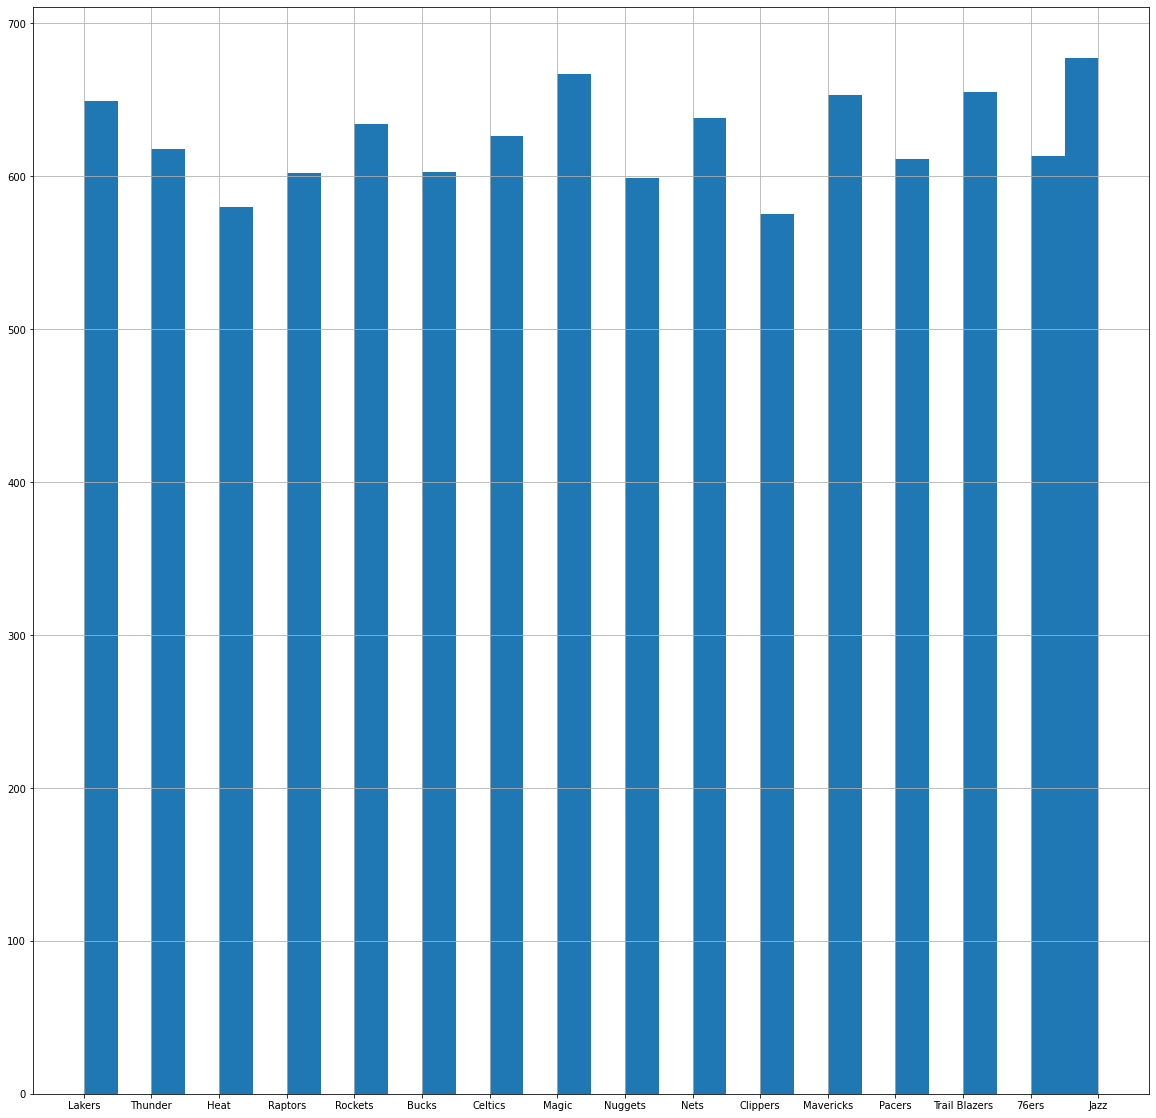

In [137]:
sim_series = pd.Series(winner_simulation)
sim_series.hist(stacked=True, bins=30, figsize=(20, 20))

In [42]:
train_data = input_data.loc[(input_data.SEASON < 2018) & (input_data.SEASON > 2005)]
test_data = input_data.loc[input_data.SEASON == 2019]
full_train_data = pd.concat([train_data], axis = 0)

X, y = train_data.drop(columns = ['HOME_TEAM_WINS']), train_data.HOME_TEAM_WINS
test_X, test_y = test_data.drop(columns = ['HOME_TEAM_WINS']), test_data.HOME_TEAM_WINS
full_train_X, full_train_y = full_train_data.drop(columns = ['HOME_TEAM_WINS', 'SEASON', 'GAME_ID']), full_train_data.HOME_TEAM_WINS

train_games = X[['SEASON', 'GAME_ID']]
test_games = test_X[['SEASON', 'GAME_ID']]

X.drop(columns = ['SEASON', 'GAME_ID'], inplace=True)
test_X.drop(columns = ['SEASON', 'GAME_ID'], inplace = True)

In [43]:
from pyspark.sql.types import *
from pyspark.sql.functions import regexp_replace, col, when, udf
from pyspark.ml.feature import Bucketizer
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import RandomForestClassifier

assembler = VectorAssembler(
    inputCols=['SEASON', 'W', 'L', 'EFF', 'HOME_ELO', 'W_VISITOR', 'L_VISITOR', 'EFF_VISITOR',
               'VISITOR_ELO', 'ELO_DIFF', 'EFF_DIFF', 'HOME_W','HOME_L','AWAY_W','AWAY_L'],
    outputCol="features",
    handleInvalid='keep')

rf = RandomForestClassifier(labelCol="HOME_TEAM_WINS", featuresCol="features", numTrees=10)

pipeline = Pipeline(stages = [assembler, rf])

training_df = spark.createDataFrame(train_data)
test_df = spark.createDataFrame(test_data)

model = pipeline.fit(training_df)

df_predictions = model.transform(test_df)
df_pandas = df_predictions.toPandas()

df_predictions.createOrReplaceTempView('predictions_dataset')
porcentaje_de_aciertos = spark.sql("select (1 - mean(abs(HOME_TEAM_WINS - prediction))) as Porcentaje_de_Aciertos from predictions_dataset")
porcentaje_de_aciertos.show()

+----------------------+
|Porcentaje_de_Aciertos|
+----------------------+
|    0.6604747162022704|
+----------------------+



In [44]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="HOME_TEAM_WINS", rawPredictionCol="prediction", metricName='areaUnderROC')
auc = evaluator.evaluate(df_predictions)
auc

0.6458724202626642

# FALTA

- Adaptar simulacion al modelo *
- Agregar W y L *
- Agregar efficency igual al ELO (fija del principio de temporada) *
- Simular missing players usando la prob de perder jugadores de los datos *ponele
- Simular partidos de local y visitante *
- Generar apuestas 
- Hacer analisis de datos previos *
- Hacer gráficas*
- Hacer presentación *
- Agregar home/away wins y loses*

In [86]:
team_data

,ELO,EFF,MISSING_PLAYERS,G,W,L,HOME_W,HOME_L,AWAY_W,AWAY_L,ABBREVIATION,NICKNAME
TEAM_ID,,,,,,,,,,,,
1610612737,1507.793798,978.500000,2,66.0,20.0,46.0,14.0,19.0,6.0,27.0,ATL,Hawks
1610612738,1789.682073,995.625000,2,63.0,42.0,21.0,23.0,9.0,19.0,12.0,BOS,Celtics
1610612739,1466.823732,1010.500000,3,64.0,19.0,45.0,11.0,25.0,8.0,20.0,CLE,Cavaliers
1610612740,1655.247664,945.000000,4,63.0,27.0,36.0,13.0,19.0,14.0,17.0,NOP,Pelicans
1610612741,1512.049154,1001.166667,3,64.0,21.0,43.0,13.0,20.0,8.0,23.0,CHI,Bulls
1610612742,1719.369751,886.250000,1,66.0,39.0,27.0,18.0,15.0,21.0,12.0,DAL,Mavericks
1610612743,1759.700579,1154.625000,1,64.0,43.0,21.0,25.0,8.0,18.0,13.0,DEN,Nuggets
1610612744,1675.967024,906.625000,3,64.0,15.0,49.0,8.0,25.0,7.0,24.0,GSW,Warriors
1610612745,1757.760819,1153.857143,1,63.0,39.0,24.0,21.0,10.0,18.0,14.0,HOU,Rockets


In [87]:
from pyspark.sql.types import StructType,StructField

home_elo = team_data[team_data['NICKNAME'] == 'Bucks']['ELO'].tolist()[0]
visit_elo = team_data[team_data['NICKNAME'] == 'Pistons']['ELO'].tolist()[0]
home_eff = team_data[team_data['NICKNAME'] == 'Bucks']['EFF'].tolist()[0]
visit_eff = team_data[team_data['NICKNAME'] == 'Pistons']['EFF'].tolist()[0]
w = team_data[team_data['NICKNAME'] == 'Bucks']['W'].tolist()[0]
l = team_data[team_data['NICKNAME'] == 'Bucks']['L'].tolist()[0]
w_vis = team_data[team_data['NICKNAME'] == 'Pistons']['W'].tolist()[0]
l_vis = team_data[team_data['NICKNAME'] == 'Pistons']['L'].tolist()[0]
season = 2019
home_w = team_data[team_data['NICKNAME'] == 'Bucks']['HOME_W'].tolist()[0]
home_l = team_data[team_data['NICKNAME'] == 'Bucks']['HOME_L'].tolist()[0]
away_w = team_data[team_data['NICKNAME'] == 'Bucks']['AWAY_W'].tolist()[0]
away_l = team_data[team_data['NICKNAME'] == 'Bucks']['AWAY_L'].tolist()[0]
home_w_vis = team_data[team_data['NICKNAME'] == 'Bucks']['HOME_W'].tolist()[0]
home_l_vis = team_data[team_data['NICKNAME'] == 'Bucks']['HOME_L'].tolist()[0]
away_w_vis = team_data[team_data['NICKNAME'] == 'Bucks']['AWAY_W'].tolist()[0]
away_l_vis = team_data[team_data['NICKNAME'] == 'Bucks']['AWAY_L'].tolist()[0]

def create_df(season, w, l, home_eff, home_elo, home_w, home_l, away_w, away_l, w_vis, l_vis, visit_eff, visit_elo, home_w_vis, home_l_vis, away_w_vis, away_l_vis):

    input_col = [(season,
                 w,
                 l,
                 home_eff,
                 home_elo,
                 home_w,
                 home_l,
                 away_w,
                 away_l,
                 w_vis,
                 l_vis,
                 visit_eff,
                 visit_elo,
                 home_w_vis,
                 home_l_vis,
                 away_w_vis,
                 away_l_vis,
                 home_elo - visit_elo,
                 home_eff - visit_eff)]

    schema = StructType([       
        StructField('SEASON', IntegerType(), True),
        StructField('W', DoubleType(), True),
        StructField('L', DoubleType(), True),
        StructField('EFF', DoubleType(), True),
        StructField('HOME_ELO', DoubleType(), True),
        StructField('HOME_W', DoubleType(), True),
        StructField('HOME_L', DoubleType(), True),
        StructField('AWAY_W', DoubleType(), True),
        StructField('AWAY_L', DoubleType(), True),
        StructField('W_VISITOR', DoubleType(), True),
        StructField('L_VISITOR', DoubleType(), True),
        StructField('EFF_VISITOR', DoubleType(), True),
        StructField('VISITOR_ELO', DoubleType(), True),
        StructField('HOME_W_VISITOR', DoubleType(), True),
        StructField('HOME_L_VISITOR', DoubleType(), True),
        StructField('AWAY_W_VISITOR', DoubleType(), True),
        StructField('AWAY_L_VISITOR', DoubleType(), True),
        StructField('ELO_DIFF', DoubleType(), True),
        StructField('EFF_DIFF', DoubleType(), True)
    ])
    deptDF1 = spark.createDataFrame(data=input_col, schema = schema)
    return deptDF1

In [114]:
def rnd(home, visit):
    if np.random.rand() < 0.5:
        home, visit = visit, home
        
    home_elo = team_data[team_data['NICKNAME'] == home]['ELO'].tolist()[0]
    visit_elo = team_data[team_data['NICKNAME'] == visit]['ELO'].tolist()[0]
    home_eff = team_data[team_data['NICKNAME'] == home]['EFF'].tolist()[0]
    visit_eff = team_data[team_data['NICKNAME'] == visit]['EFF'].tolist()[0]
    w = team_data[team_data['NICKNAME'] == home]['W'].tolist()[0]
    l = team_data[team_data['NICKNAME'] == home]['L'].tolist()[0]
    home_w = team_data[team_data['NICKNAME'] == home]['HOME_W'].tolist()[0]
    home_l = team_data[team_data['NICKNAME'] == home]['HOME_L'].tolist()[0]
    away_w = team_data[team_data['NICKNAME'] == home]['AWAY_W'].tolist()[0]
    away_l = team_data[team_data['NICKNAME'] == home]['AWAY_L'].tolist()[0]
    w_vis = team_data[team_data['NICKNAME'] == visit]['W'].tolist()[0]
    l_vis = team_data[team_data['NICKNAME'] == visit]['L'].tolist()[0]
    home_w_vis = team_data[team_data['NICKNAME'] == visit]['HOME_W'].tolist()[0]
    home_l_vis = team_data[team_data['NICKNAME'] == visit]['HOME_L'].tolist()[0]
    away_w_vis = team_data[team_data['NICKNAME'] == visit]['AWAY_W'].tolist()[0]
    away_l_vis = team_data[team_data['NICKNAME'] == visit]['AWAY_L'].tolist()[0]
    season = 2019
    aux_df = create_df(season, w, l, home_eff, home_elo, home_w, home_l, away_w, away_l, w_vis, l_vis, visit_eff, visit_elo, home_w_vis, home_l_vis, away_w_vis, away_l_vis)
    
    thld = model.transform(aux_df).toPandas()['probability'][0][1]
    if np.random.rand() < thld:
        return home
    else:
        return visit
    
def simulate_series(home, visit):
    serie = [rnd(home, visit) for i in range(0,7)]
    if serie.count(home) >= 4:
        return home
    else: 
        return visit 
    
def simulate_conference(equipo_1, equipo_2, equipo_3, equipo_4, equipo_5, equipo_6, equipo_7, equipo_8):
    series_winner_1 = simulate_series(equipo_1, equipo_8)
    series_winner_2 = simulate_series(equipo_2, equipo_7)
    series_winner_3 = simulate_series(equipo_3, equipo_6)
    series_winner_4 = simulate_series(equipo_4, equipo_5)
    series_winner_5 = simulate_series(series_winner_1, series_winner_4)
    series_winner_6 = simulate_series(series_winner_2, series_winner_3)
    return simulate_series(series_winner_5, series_winner_6)

def simulate_final(east_conf_winner, west_conf_winner):
    print("simulate")
    return simulate_series(east_conf_winner, west_conf_winner)

def simulate_playoffs(equipo_1, equipo_2, equipo_3, equipo_4, equipo_5, equipo_6, equipo_7, equipo_8,equipo_9, equipo_10, equipo_11, equipo_12, equipo_13, equipo_14, equipo_15, equipo_16):
    east_conf_winner = simulate_conference(equipo_1, equipo_2, equipo_3, equipo_4, equipo_5, equipo_6, equipo_7, equipo_8)
    west_conf_winner = simulate_conference(equipo_9, equipo_10, equipo_11, equipo_12, equipo_13, equipo_14, equipo_15, equipo_16)
    return simulate_final(east_conf_winner, west_conf_winner)

# 2019

In [126]:
train_data = input_data.loc[(input_data.SEASON < 2019) & (input_data.SEASON > 2005)]
test_data = input_data.loc[input_data.SEASON == 2019]
full_train_data = pd.concat([train_data], axis = 0)

X, y = train_data.drop(columns = ['HOME_TEAM_WINS']), train_data.HOME_TEAM_WINS
test_X, test_y = test_data.drop(columns = ['HOME_TEAM_WINS']), test_data.HOME_TEAM_WINS
full_train_X, full_train_y = full_train_data.drop(columns = ['HOME_TEAM_WINS', 'SEASON', 'GAME_ID']), full_train_data.HOME_TEAM_WINS

train_games = X[['SEASON', 'GAME_ID']]
test_games = test_X[['SEASON', 'GAME_ID']]

X.drop(columns = ['SEASON', 'GAME_ID'], inplace=True)
test_X.drop(columns = ['SEASON', 'GAME_ID'], inplace = True)

model = pipeline.fit(training_df)

In [127]:
equipo_1 = 'Lakers'
equipo_2 = 'Clippers' 
equipo_3 = 'Nuggets'
equipo_4 = 'Rockets'
equipo_5 = 'Thunder'
equipo_6 = 'Jazz'
equipo_7 = 'Mavericks'
equipo_8 = 'Trail Blazers'

equipo_9 = 'Bucks'
equipo_10 = 'Raptors'
equipo_11 = 'Celtics'
equipo_12 = 'Pacers'
equipo_13 = 'Heat'
equipo_14 = '76ers'
equipo_15 = 'Nets'
equipo_16 = 'Magic'


In [128]:
winner_simulation = [simulate_playoffs(equipo_1, equipo_2, equipo_3, equipo_4, equipo_5, equipo_6, equipo_7, equipo_8,equipo_9, equipo_10, equipo_11, equipo_12, equipo_13, equipo_14, equipo_15, equipo_16)
                     for i in range(0, 100)]

simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate


<AxesSubplot:>

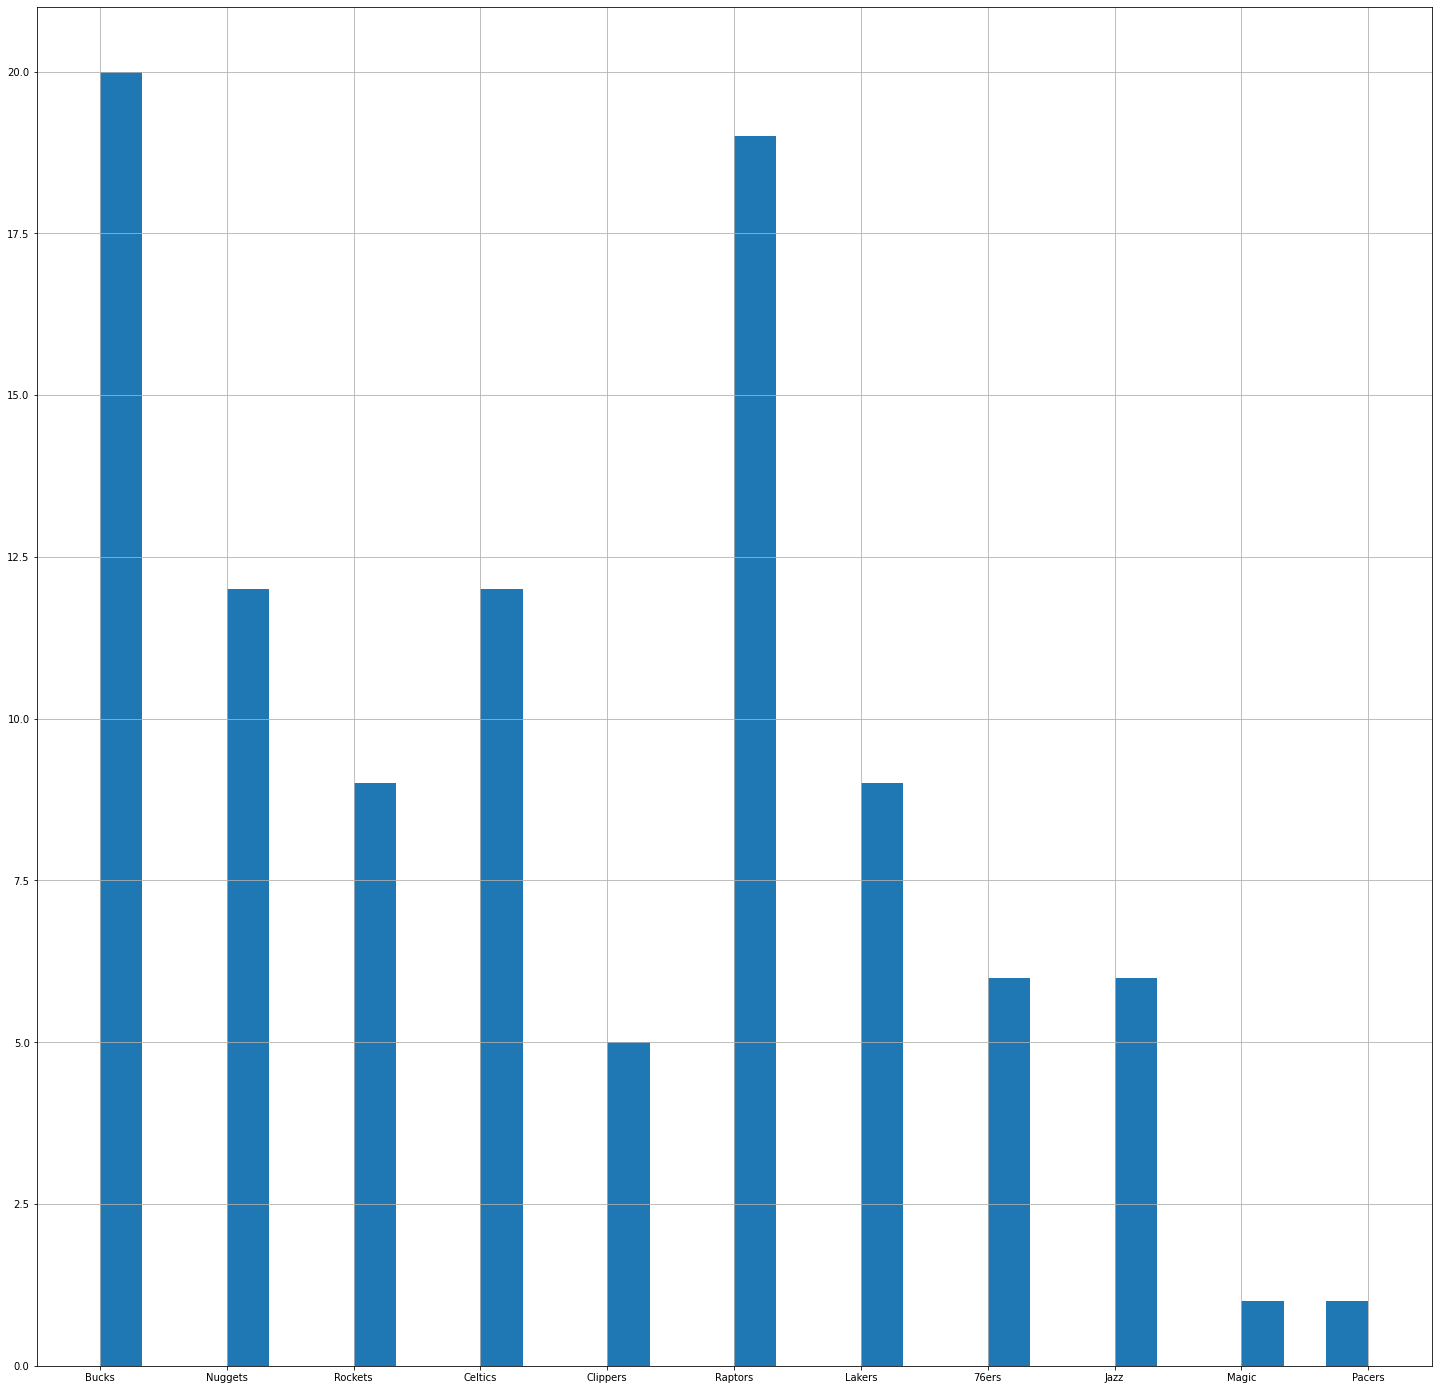

In [129]:
sim_series = pd.Series(winner_simulation)
sim_series.hist(stacked=True, bins=30, figsize=(25, 25))

# 2020

In [121]:
train_data = input_data.loc[(input_data.SEASON < 2020) & (input_data.SEASON > 2005)]
test_data = input_data.loc[input_data.SEASON == 2020]
full_train_data = pd.concat([train_data], axis = 0)

X, y = train_data.drop(columns = ['HOME_TEAM_WINS']), train_data.HOME_TEAM_WINS
test_X, test_y = test_data.drop(columns = ['HOME_TEAM_WINS']), test_data.HOME_TEAM_WINS
full_train_X, full_train_y = full_train_data.drop(columns = ['HOME_TEAM_WINS', 'SEASON', 'GAME_ID']), full_train_data.HOME_TEAM_WINS

train_games = X[['SEASON', 'GAME_ID']]
test_games = test_X[['SEASON', 'GAME_ID']]

X.drop(columns = ['SEASON', 'GAME_ID'], inplace=True)
test_X.drop(columns = ['SEASON', 'GAME_ID'], inplace = True)

model = pipeline.fit(training_df)

In [122]:
equipo_1 = 'Jazz'
equipo_2 = 'Suns' 
equipo_3 = 'Nuggets'
equipo_4 = 'Clippers'
equipo_5 = 'Mavericks'
equipo_6 = 'Trail Blazers'
equipo_7 = 'Lakers'
equipo_8 = 'Grizzlies'

equipo_9 = '76ers'
equipo_10 = 'Nets'
equipo_11 = 'Bucks'
equipo_12 = 'Knicks'
equipo_13 = 'Hawks'
equipo_14 = 'Heat'
equipo_15 = 'Celtics'
equipo_16 = 'Wizards'

In [123]:
home_elo = team_data[team_data['NICKNAME'] == 'Bucks']['ELO'].tolist()[0]
visit_elo = team_data[team_data['NICKNAME'] == 'Pistons']['ELO'].tolist()[0]
home_eff = team_data[team_data['NICKNAME'] == 'Bucks']['EFF'].tolist()[0]
visit_eff = team_data[team_data['NICKNAME'] == 'Pistons']['EFF'].tolist()[0]
w = team_data[team_data['NICKNAME'] == 'Bucks']['W'].tolist()[0]
l = team_data[team_data['NICKNAME'] == 'Bucks']['L'].tolist()[0]
w_vis = team_data[team_data['NICKNAME'] == 'Pistons']['W'].tolist()[0]
l_vis = team_data[team_data['NICKNAME'] == 'Pistons']['L'].tolist()[0]
season = 2020

In [124]:
winner_simulation = [simulate_playoffs(equipo_1, equipo_2, equipo_3, equipo_4, equipo_5, equipo_6, equipo_7, equipo_8,equipo_9, equipo_10, equipo_11, equipo_12, equipo_13, equipo_14, equipo_15, equipo_16)
                     for i in range(0, 100)]

simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate
simulate


<AxesSubplot:>

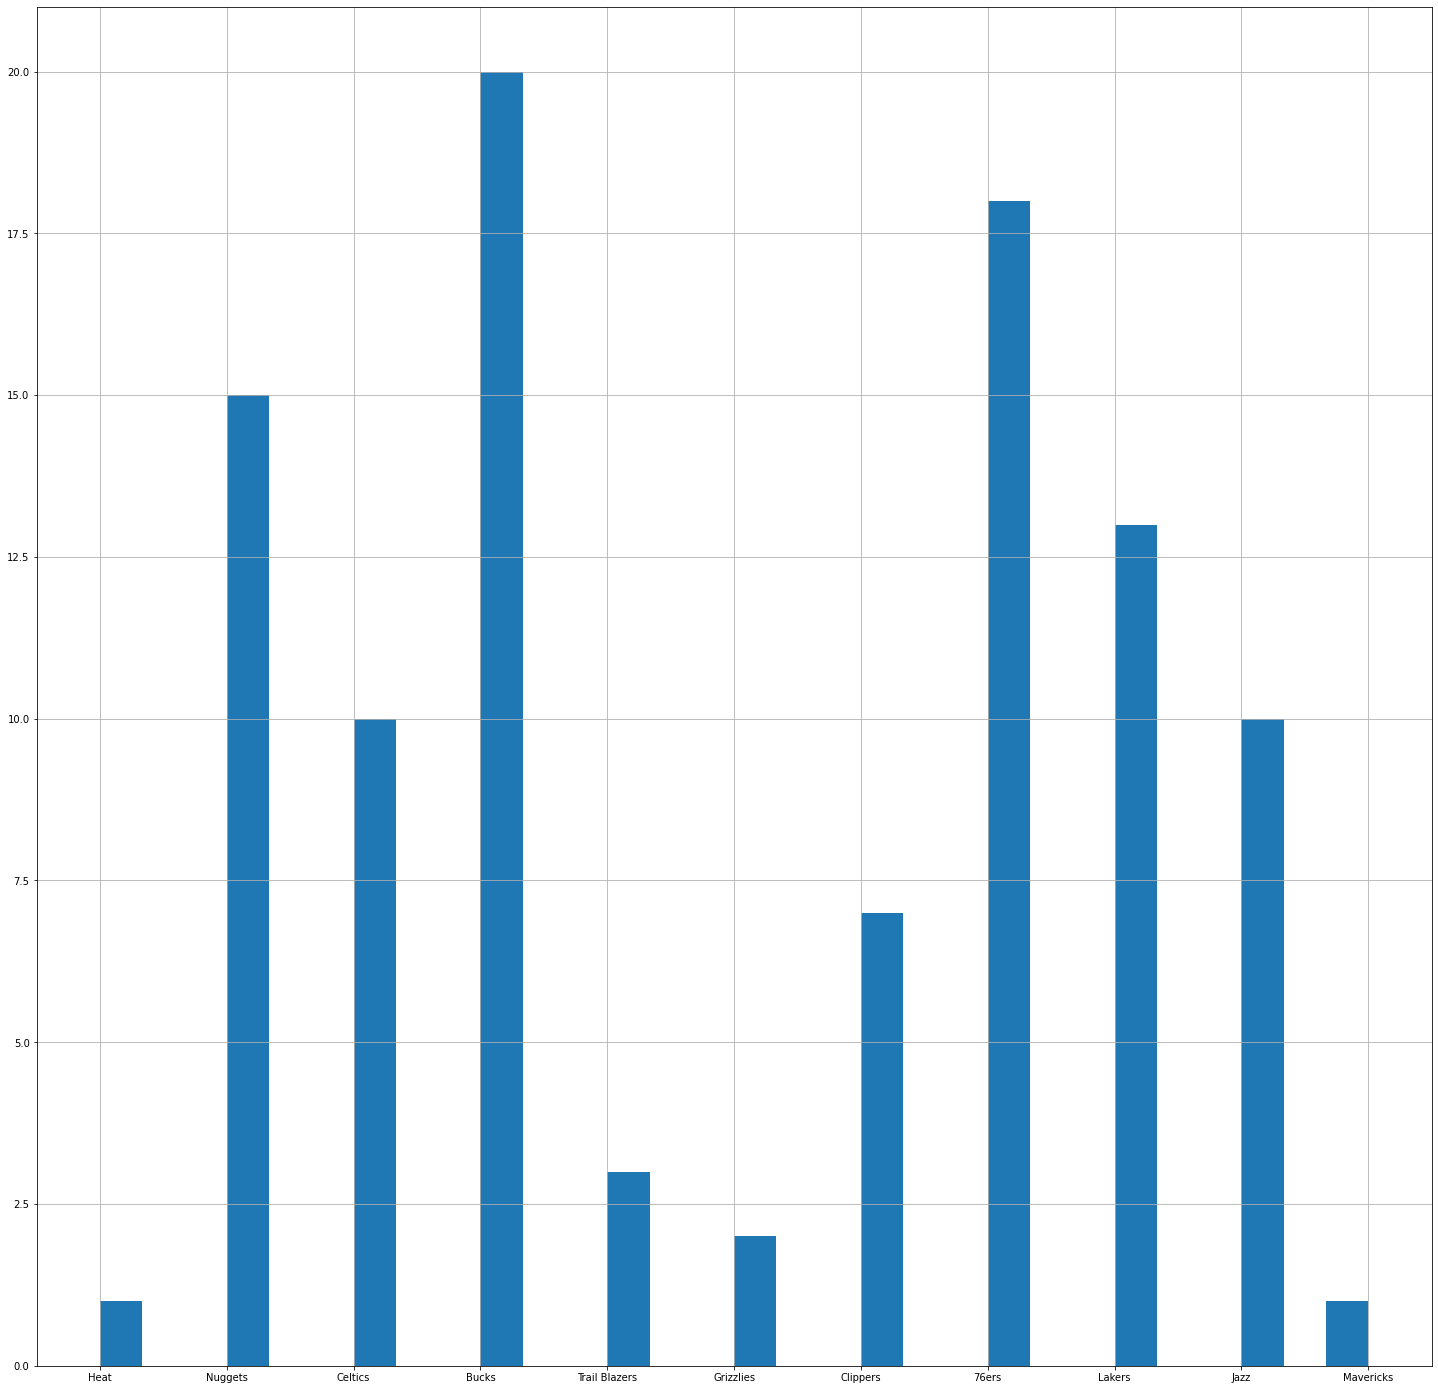

In [125]:
sim_series = pd.Series(winner_simulation)
sim_series.hist(stacked=True, bins=30, figsize=(25, 25))